\title{Upsampling and Downsampling in myHDL}
\author{Steven K Armour}
\maketitle

# Python Libraries Utilized

In [1]:
import numpy as np
import scipy.signal as sig
import pandas as pd

from sympy import *
init_printing()
from IPython.display import display, Math, Latex
 
from myhdl import *
from myhdlpeek import Peeker

import matplotlib.pyplot as plt
%matplotlib inline

# Acknowledgments
The orgianl Interpolation Decimation componetswritten in myHDL was done by [Christopher Felton](https://github.com/cfelton)
(myHDL.old version [here](https://github.com/jandecaluwe/site-myhdl-retired/blob/master/_ori/pages/projects/gciccomplete.txt))

Author of myHDL [Jan Decaluwe](http://www.myhdl.org/users/jandecaluwe.html) and the author of the myHDL Peeker [XESS Corp.](https://github.com/xesscorp/myhdlpeek)


# Refrances 

# Down Sampling via Decimation

In DownSmapling by decmiation the input signal $x(n)$ is feed into the downsampler and the output is then shifted to the downshifted signal $x_d(Dn)$ where the down sampleing factor $D\geq$. In a analog time system the Downsampling action would be intupirted to be exsapnsive time scaling. In the discrate space downsampleing a alreaddy sampled signal is the action of skiping every $D$ inputs to the dowmsample. Effectivly removing, aka decmating, those inputs by the action of skiping them

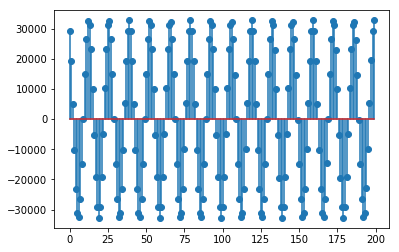

In [2]:
TestValues=pd.read_pickle('SinGen16.pkl')
TestValues.head(16)
plt.stem(TestValues['GenValue'])
None

In [3]:
1/TestValues['Time[s]'][1]

The test data that is being used has 200 samples in 20$mu$ sec with a sampling rate of 10 MHz. We can see what the result of downsampling will be via the following

<Container object of 3 artists>

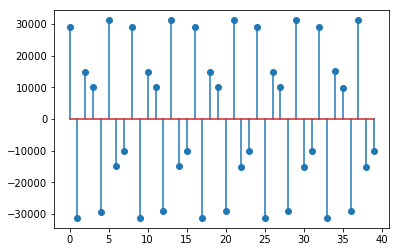

In [4]:
D=5
plt.stem(TestValues['GenValue'][::D])

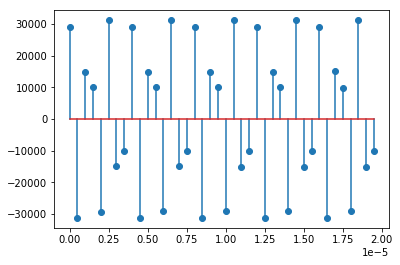

In [5]:
plt.stem(TestValues['Time[s]'][::D], TestValues['GenValue'][::D])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

by the nyqest condidtion that the lowest sampling rate must be $f_s>2\max{f_a}$ and by using a downsampler the myquest condtion becomes $f_s>2D\max{f_a}$. Therefore the upper bound of D in order to not incurre the penility of ailissing is $D<\dfrac{f_s}{2\max{f_a}}$ where ofcource $D$ is an integer satifying affor mentioned condidtion

# myHDL implimintaion of a Decimator

in python we simpling use slicing to performthe action of Decimation blindly, however in order to implimint this at the hardware level the layers of aprstarion in slicing must be peeled back

When the slice ```x[::D]``` is taken we are telling python to return the nth value after egnoring D intermited values. How python (or any other programing language does this is) is by estaplishing a counter that counts eather up to and down from the the skip factor, returing the now nth value and then reseting that counter and performing that action to a end condition is meet. In order to do this via a single HDL object it will have be broken down into two internal componets. One componet is the afored mentioned counter and the other is the counter watcher that allows the nth input to pass through it if counter reaches the skip number D.

In [6]:
def Decimator(x_in, y_out,  clk, rst, D_parm=2):
    """
    Parameters:
    -----------
    D_parm: The Decimation (downsampling factor) value in base 10
    
    Ports:
    ------
    x_in:    2's compliment input
    y_out:    2's compliment output
    clk:  System clock, must be equal to or greater than the max
          sample rate after interpolation or before decimation
    rst:  System reset
    """
    
    D_base2= int(np.ceil(np.log2(D_parm)))
    Count=Signal(intbv(0, max=2**D_base2))
    
    @always(clk.posedge)
    def counter():
        if rst:
            Count.next=0
        else:
            #recyle the count
            if Count==D_parm-1:
                Count.next=0
            #up incrimite counter upwards to D_parm
            else:
                Count.next=Count+1
                
    @always(clk.posedge)
    def action():
        if rst:
            y_out.next=0
        else:
            #counter has terminated
            if Count==0:
                y_out.next=x_in
            else:
                y_out.next=0
    
    return instances()

In [7]:
Peeker.clear()

x_in=Signal(intbv(0, max=TestValues['GenValue'].max()+1, 
                  min=TestValues['GenValue'].min()-1))
Peeker(x_in, 'x_in')

y_out=Signal(intbv(0, max=TestValues['GenValue'].max()+1, 
                   min=TestValues['GenValue'].min()-1))
Peeker(y_out, 'y_out')
DecimatorTracker=[]

clk=Signal(bool(0)); Peeker(clk, 'clk')
rst=Signal(bool(0)); Peeker(rst, 'rst')

DUT=Decimator(x_in=x_in, y_out=y_out, clk=clk, rst=rst, D_parm=5)

def Decimator_TB():
    TestValueGen=TestValues['GenValue'].iteritems()
    
    @always(delay(1))    
    def clkgen():
        clk.next = not clk
        
    @instance
    def stimules():
        for step, val in TestValueGen:
            x_in.next=int(val)
            if step==50:
                rst.next=True
            else:
                rst.next=False
            
            DecimatorTracker.append(int(y_out))
            yield clk.negedge
        
        raise StopSimulation
    
    return instances()
            
    


In [8]:
sim = Simulation(DUT, Decimator_TB(), *Peeker.instances()).run()
DecimatorTracker=np.array(DecimatorTracker)
Peeker.to_wavedrom(start_time=40, stop_time=60, tock=True)

<Container object of 3 artists>

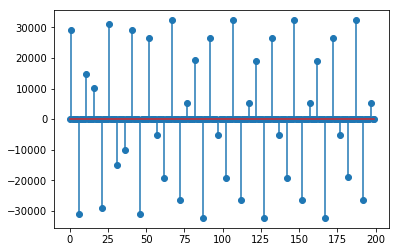

In [9]:
plt.stem(DecimatorTracker)

<Container object of 3 artists>

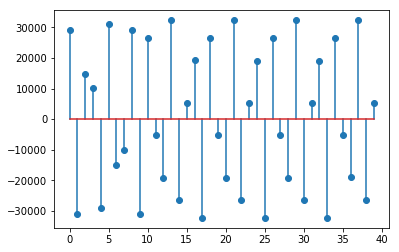

In [10]:
plt.stem(DecimatorTracker[np.nonzero(DecimatorTracker)])

# Upsampling via Interpolation

Unlike downsampling that simply ignores input values via a built in counter and passing zeros inplace of the ignored values. Upsampleing must add intermidite values between the given input. The travial way is padding a zeros between the inputs by the upsampling factor $U$; and wile this does acomplish the act of incrassing the samples all that has been done is zero padding. This can be seen as follows for a upsampling of $U=5$

In [34]:
original=list(np.array(TestValues['GenValue']))

<Container object of 3 artists>

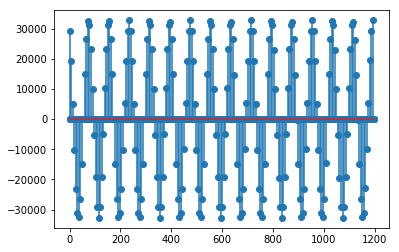

In [61]:
U=5
zeroPadding= [0]*((U+1)*len(original)-1)
zeroPadding[::U+1]=original; InterpoloteData=pd.DataFrame(zeroPadding, columns=['GenValue'])
plt.stem(InterpoloteData['GenValue'])

In [62]:
InterpoloteData.head((U+2)*2)

,GenValue
0,29196
1,0
2,0
3,0
4,0
5,0
6,19259
7,0
8,0
9,0


In [72]:
zeroPadding=np.array(zeroPadding)
zeroPadding[zeroPadding==0]=np.nan
zeroPadding[0]=0
InterpoloteData=pd.DataFrame(zeroPadding, columns=['GenValue'])

as can be seen this zero intermidite padding has not done much but to incress the number of samples. In order to make this non trival the intermited padded values must take on a value other than zero. We can accomplish this by means of interpolation by the sample and hold method. Wich happens to be rectanlge impulse function in the discrate time domain and in frequancy domn becomes the sinc function (more detail explination [here](https://en.wikipedia.org/wiki/Zero-order_hold) & [here](https://en.wikipedia.org/wiki/Rectangular_function))

In [78]:
InterpoloteData['GenValue'].interpolate(method='zero', inplace=True)

<Container object of 3 artists>

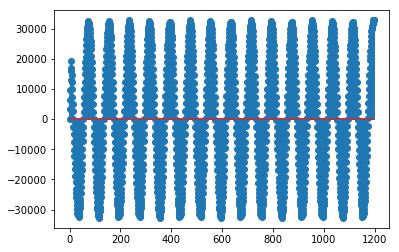

In [79]:
plt.stem(InterpoloteData['GenValue'])

as shown by using a zero order hold interpolation we can artificsly increass the sampling; and by artfical it we can see clearly that the outcome of the interpolation is not a perfect sinusiode

<Container object of 3 artists>

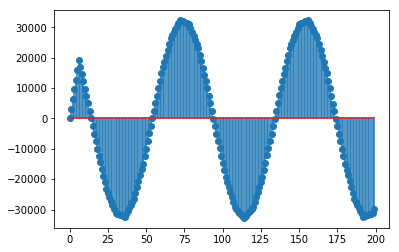

In [83]:
plt.stem(InterpoloteData['GenValue'][:200])